# Image Preparation

The first thing we need to do is get and prepare the data for which we’ll be training the CNN.

The data set we’ll use is a random subset of the data set from the Kaggle Dogs Versus Cats competition. You can download the data [here](https://kaggle.com/c/dogs-vs-cats/data).

Copy the downloaded dogs-vs-cats.zip file, and paste it into whichever directory you’d like to work from. Relative to the Jupyter notebook we'll be working in, I'm placing dogs-vs-cats.zip within a directory called data.

Now, extract dogs-vs-cats.zip, and then extract train.zip from within. We won't be working with the provided test set for the moment, so you can move the test1.zip elsewhere if you'd like.

Next, select all of the image files from within the train directory and move them into the base dogs-vs-cats directory. Lastly, delete the empty train directory.

In [1]:
# If in colab
if "google.colab" in str(get_ipython()):
    %tensorflow_version 2.x
    
import glob
import itertools
import os
import random
import shutil
import warnings

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Flatten,
    MaxPool2D,
)
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline



In [2]:
# try:
#     import autokeras as ak
#     print("autokeras imported!")
# except Exception as e:
#     !pip install autokeras
    

In [3]:
# If in colab
if "google.colab" in str(get_ipython()):
    from google.colab import drive

    drive.mount("/content/drive")

In [4]:
SEED = 24

BATCH_SIZE = 10

Using the script below, we'll organize our data into train, validation, and test sets. We'll do this by moving subsets of the data into sub-directories for each separate data set.

In [5]:
# If in colab
if "google.colab" in str(get_ipython()):
    train_path = "/content/drive/My Drive/dogs-vs-cats/train"
    valid_path = "/content/drive/My Drive/dogs-vs-cats/valid"
    test_path = "/content/drive/My Drive/dogs-vs-cats/test"
else:
    import zipfile

    zip_path = os.path.join(os.getcwd(), "dogs-vs-cats-images.zip")

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(os.getcwd())

    train_path = "dogs-vs-cats/train"
    valid_path = "dogs-vs-cats/valid"
    test_path = "dogs-vs-cats/test"

We can use Keras' ImageDataGenerator class to create batches of data from the directories we made.

Notice, to **ImageDataGenerator** for each of the data sets, we specify **preprocessing_function=tf.keras.applications.vgg16.preprocess_input**. For now, just understand this does an additional processing step on the images.

To **flow_from_directory()**, we first specify the path for the data, target_size of the images, which will resize all images to the specified size.

The **classes** parameter expects a list that contains the underlying class names, and lastly, we specify the batch_size.

We also specify **shuffle=False** only for test_batches. That's because, later when we plot the evaluation results from the model to a confusion matrix, we'll need to able to access the unshuffled labels for the test set. By default, the data sets are shuffled.

In [6]:
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    classes=["cat", "dog"],
    batch_size=BATCH_SIZE,
    seed=SEED,
)

valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input

).flow_from_directory(
    directory=valid_path,
    target_size=(224, 224),
    classes=["cat", "dog"],
    batch_size=BATCH_SIZE,
    seed=SEED,
)

test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    classes=["cat", "dog"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED,
)


Found 202 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## Visualizing The Data

In [7]:
def plots(ims, figsize=(12, 6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if ims.shape[-1] != 3:
            ims = ims.transpose((0, 2, 3, 1))
    f = plt.figure(figsize=figsize)
    cols = len(ims) // rows if len(ims) % 2 == 0 else len(ims) // rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i + 1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        
        # plt.figure(figsize=(8, 8))
        plt.imshow(ims[i], interpolation=None if interp else "none")

H:\Programming\Python\env\env_conda_38_tensorflow_gpu_autokeras\lib\site-packages\PIL\Image.py
H:\Programming\Python\env\env_conda_38_tensorflow_gpu_autokeras\lib\site-packages\PIL\Image.py


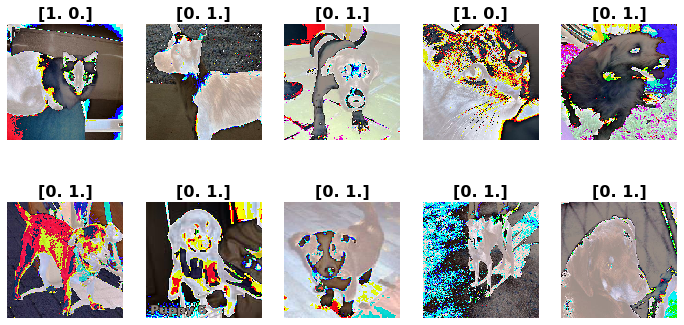

In [8]:
import sys

from PIL import Image

sys.modules["Image"] = Image
print(Image.__file__)
import Image
print(Image.__file__)


test_imgs, test_lables = next(train_batches)
plots(test_imgs, titles=test_lables, rows=2)

# Build And Train A Convolutional Neural Network With TensorFlow's Keras API

The pre-trained model we'll be working with to classify images of cats and dogs is called VGG16.

We’ll import this VGG16 model and then fine-tune it using Keras. The fine-tuned model will only work to classify images as either cats or dogs.

In [9]:
"""
Download vgg16 model and import vgg16 model
"""
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We then iterate over each of the layers in vgg16_model, except for the last layer, and add each layer to the new Sequential model.

In [10]:
"""
create a new model that will obtain the same layers as the vgg16 model
"""

# New model
model_new = Sequential()

# Copy the layyers into the new model excluding the last layer because we want a custom prediction layer
for i in range(0, len(vgg16_model.layers) - 1):
    layer = vgg16_model.layers[i]
    model_new.add(layer)
    
model_new.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

Next, we’ll iterate over each of the layers in our new Sequential model and set them to be non-trainable. This freezes the weights and other trainable parameters in each layer so that they will not be trained or updated when we later pass in our images of cats and dogs.

In [11]:
"""
Don't train the copied layers from the vgg16 model in the new model because we are doing transfer learning.
Recall the last last layer of the vgg16 model was predictions and it is not in this new model because we need to
add our own layer.
"""
for layer in model_new.layers:
    layer.trainable = False

# Add new last layer
model_new.add(Dense(2, activation="softmax"))

In [12]:
model_new.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

## Training the CNN

We have to fit the model with our data.

We need to specify **steps_per_epoch** to indicate how many batches of samples from our training set should be passed to the model before declaring one epoch complete. 

In [13]:
model_new.compile(Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"]
                  )

In [14]:
%timeit
history = model_new.fit(
    train_batches,
    validation_data=valid_batches,
    # batch_size = 64,  # Custom, I added
    steps_per_epoch=train_batches.samples // BATCH_SIZE,
    validation_steps=valid_batches.samples // BATCH_SIZE,
    epochs=100,  # Original == 20
    verbose=2,
)

Epoch 1/100
20/20 - 6s - loss: 0.8339 - accuracy: 0.5990 - val_loss: 0.4546 - val_accuracy: 0.7875
Epoch 2/100
20/20 - 1s - loss: 0.2856 - accuracy: 0.8854 - val_loss: 0.2554 - val_accuracy: 0.8250
Epoch 3/100
20/20 - 1s - loss: 0.1968 - accuracy: 0.9375 - val_loss: 0.1781 - val_accuracy: 0.9000
Epoch 4/100
20/20 - 1s - loss: 0.1281 - accuracy: 0.9635 - val_loss: 0.1392 - val_accuracy: 0.9375
Epoch 5/100
20/20 - 1s - loss: 0.0925 - accuracy: 0.9740 - val_loss: 0.1242 - val_accuracy: 0.9625
Epoch 6/100
20/20 - 1s - loss: 0.0737 - accuracy: 0.9792 - val_loss: 0.1111 - val_accuracy: 0.9625
Epoch 7/100
20/20 - 1s - loss: 0.0593 - accuracy: 0.9896 - val_loss: 0.1003 - val_accuracy: 0.9500
Epoch 8/100
20/20 - 1s - loss: 0.0494 - accuracy: 0.9948 - val_loss: 0.0956 - val_accuracy: 0.9500
Epoch 9/100
20/20 - 1s - loss: 0.0416 - accuracy: 1.0000 - val_loss: 0.0900 - val_accuracy: 0.9625
Epoch 10/100
20/20 - 1s - loss: 0.0347 - accuracy: 1.0000 - val_loss: 0.0835 - val_accuracy: 0.9750
Epoch 11/

In [15]:
import pandas as pd

display(pd.DataFrame(history.history))

,loss,accuracy,val_loss,val_accuracy
0,0.833897,0.598958,0.454613,0.7875
1,0.285573,0.885417,0.255450,0.8250
2,0.196771,0.937500,0.178100,0.9000
3,0.128134,0.963542,0.139195,0.9375
4,0.092470,0.973958,0.124173,0.9625
...,...,...,...,...
95,0.000991,1.000000,0.036233,0.9875
96,0.000993,1.000000,0.036281,0.9875
97,0.000952,1.000000,0.036249,0.9875
98,0.000997,1.000000,0.035936,0.9875


In [16]:
test_loss, test_acc = model_new.evaluate(
    test_batches,
    steps=len(test_batches),  # *** If you want to check for all batches, you must do this and not steps=1
    verbose=0
)
print(test_loss)
print(test_acc)

0.10329008847475052
0.9549999833106995


# Predictions with Keras API

In [17]:
# Extract a batch of images and labels from test set
test_imgs, test_labels = next(test_batches)


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


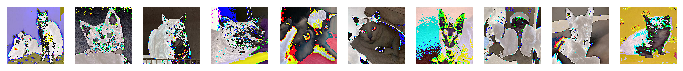

In [18]:
plots(test_imgs)
print(test_labels)

In [19]:
predictions = model_new.predict(
    x=test_batches,
    steps=len(test_batches),  # Must be this and not 1
    verbose=1
)


20/20 [==============================] - 2s 23ms/step


In [20]:
import pandas as pd

# Make DF to compare Correct value to Model Prediction
df_accuracy = pd.concat(
    [
        pd.DataFrame(np.round(predictions)),  # Version 1 of displaying the correct class prediction by having the classes side by side
        pd.DataFrame(predictions.argmax(axis=1)),  # Version 2 of displaying the correct class prediction by stating the correct class index
        pd.DataFrame(test_batches.classes)
    ], axis=1)

# Diaply entire DF
pd.set_option('display.max_rows', df_accuracy.shape[0]+1)

# Set corret column names
df_accuracy.columns = ['Class 0', 'Class 1', 'argmax', 'True Value']

# Make sure that Class 1 matches True value (Recall that we use rounding)
df_accuracy["Class 1 == True Value"] = df_accuracy['Class 1'] == df_accuracy['True Value']

# Make sure that argmax matches True value (Recall that we use argmax on axis=1)
df_accuracy["argmax == True Value"] = df_accuracy['argmax'] == df_accuracy['True Value']

df_accuracy_wrong = df_accuracy[df_accuracy['argmax'] != df_accuracy['True Value']]

# print("Testing np.round(predictions) vs (predictions.argmax(axis=1)")
# display(df_accuracy)

print("This is where the model failed to predict the correct class")
display(df_accuracy_wrong)

This is where the model failed to predict the correct class


,Class 0,Class 1,argmax,True Value,Class 1 == True Value,argmax == True Value
65,0.0,1.0,1,0,False,False
70,0.0,1.0,1,0,False,False
103,1.0,0.0,0,1,False,False
118,1.0,0.0,0,1,False,False
124,1.0,0.0,0,1,False,False
127,1.0,0.0,0,1,False,False
144,1.0,0.0,0,1,False,False
146,1.0,0.0,0,1,False,False
182,1.0,0.0,0,1,False,False


## Plotting Predictions With a Confusion Matrix

In [21]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(title + "_cat_dog")

In [22]:
cm = confusion_matrix(
    y_true=test_batches.classes,
    y_pred=np.argmax(predictions, axis=1)
)

In [23]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[98  2]
 [ 7 93]]


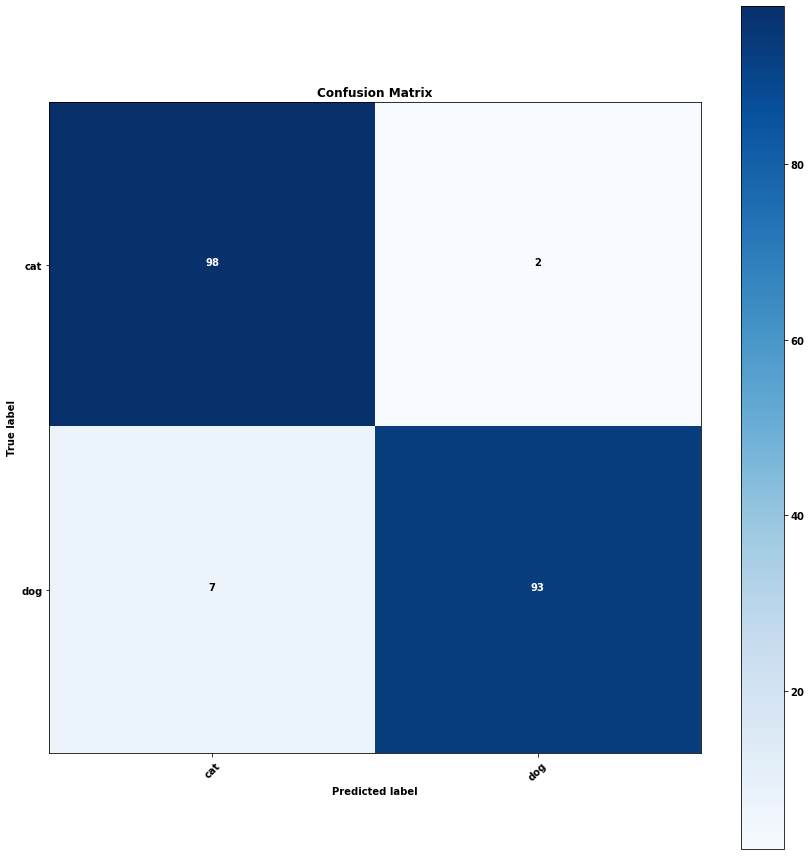

In [24]:
cm_plot_labels = ["cat", "dog"]

plot_confusion_matrix(cm=cm, 
                      classes=cm_plot_labels, 
                      title="Confusion Matrix")

In [25]:
def save_best_model(path_abs_model, model_given, test_batches_given, steps, optimzier=Adam(learning_rate=.0001), loss='categorical_crossentropy', metricts=['accuracy']):

    import tensorflow as tf
    import os

    model_given_test_loss, model_given_test_acc = model_given.evaluate(
        test_batches_given,
        steps=steps,
        verbose=1
    )

    # Save if there is no model to compare to
    if not os.path.exists(path_abs_model):
        print(f"Current model with acc ({model_given_test_acc}) is saved!")
        model_given.save(path_abs_model)
        return

    model_existing = tf.keras.models.clone_model(model_given)
    model_existing.load_weights(path_abs_model)

    model_existing.compile(optimzier,
                           loss=loss,
                           metrics=metricts)

    model_existing_test_loss, model_existing_test_acc = model_existing.evaluate(
        test_batches_given,
        steps=steps,
        verbose=1
    )

    # Save model given if it's better than the existing one
    if model_given_test_acc >= model_existing_test_acc:
        print(
            f"Current model with acc ({model_given_test_acc}) is better than Existing model with acc ({model_existing_test_acc}) and is saved!")
        model_existing.save(path_abs_model)

    else:
        print(
            f"Existing model with acc ({model_existing_test_acc}) is better than Current model with acc ({model_given_test_acc})")

In [26]:
save_best_model('weights_cats_and_dogs_VGG16_fine_tuned.h5', model_new, test_batches, len(test_batches))

model_new.load_weights('weights_cats_and_dogs_VGG16_fine_tuned.h5')
print("Model Loaded.")

20/20 [==============================] - 1s 24ms/step - loss: 0.0684 - accuracy: 0.9750
Existing model with acc (0.9750000238418579) is better than Current model with acc (0.9549999833106995)
Model Loaded.
